# Starbucks Capstone Challenge

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

## Problem Statement

Based on the information given above, we can infer that any transaction made by a customer is something really desired. No matter what offer you'd provide to the customers, still, you will deserve a transaction. Therefore, this project will try **to predict how much money a customer will spend**.

To solve the problem, we will use all datasets provided.

We will employ several machine learning algorithms. As this will be a regression problem, we will evaluate the algorithms based on several regression metrics, i.e. mean absolute error, mean squared error, root mean squared error, and R2 score.

# Datasets Description

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Set Google Colab dir

In case you run the notebook in Google Colab, run the two cells below

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Starbucks')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Starbucks'

# Explore Datasets

In [3]:
!pip install auto-sklearn

     |████████████████████████████████| 6.3 MB 3.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 22.3 MB 59.0 MB/s 
     |████████████████████████████████| 722 kB 48.3 MB/s 
     |████████████████████████████████| 4.2 MB 35.5 MB/s 
     |████████████████████████████████| 4.0 MB 37.1 MB/s 
     |████████████████████████████████| 208 kB 44.5 MB/s 
     |████████████████████████████████| 973 kB 42.2 MB/s 
     |████████████████████████████████| 132 kB 48.9 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.2-py3-none-any.whl size=6586738 sha256=037cd07aa257b965d1daac7a0f03ceff63ab387cc5ce01bd5ad7b75eb0ef5e53
  Stored in directory: /root/.cache/pip/wheels/b6/ba/aa/ce7b8deb41019b9c1c6cd0b511d553350b7075ba1d3f0f545c
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=9608a9ce0bca870974dfe17bb956efcc9d69ec138d864c886a02bdba4e7681

In [5]:
from joblib import parallel_backend

In [1]:
# import libraries
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from autosklearn.regression import AutoSklearnRegressor

import torch
from torch import nn

In [5]:
def display_all(df, what='row'):
    """used to display all rows/columns of given df"""
    with pd.option_context('display.max_' + what, None):
        display(df)

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore `portfolio` dataset

In [ ]:
portfolio.info()
portfolio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


We can see above that the `portfolio` dataset consists of 10 rows and 6 columns. No null values found.

For each row in the `channels` column, there's a list value. We're going to split each of them and make one-hot encoding for each.

In [ ]:
def split_channels(row):
    """used to split value in the channels col"""

    channel_list = ['email', 'mobile', 'social', 'web']
    output = []
    for channel in channel_list:
        if channel in row:
            output.append(1)
        else:
            output.append(0)
    return pd.Series(output)

In [ ]:
# split the channels col
tmp_channels = portfolio.channels.apply(split_channels) \
                .rename(columns={0: 'email',
                                 1: 'mobile',
                                 2: 'social',
                                 3: 'web'})

# concat the split values to the main df then drop the previous one
portfolio = pd.concat([portfolio, tmp_channels], axis=1) \
            .drop(columns='channels') \
            .rename(columns={'id': 'offer_id'})
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


Nice. It's clean for now, at least. Let's move on to the `profile` dataset.

## Explore `profile` dataset

In [ ]:
profile.info()
profile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The dataset consists much more rows than the `portfolio` dataset. The `profile` dataset also contains many `NaNs`. The `id` column looks inconsistent and could refer to ambiguity. Let's rename it.

In [ ]:
# rename the 'id' col
profile.rename(columns={'id': 'customer_id'}, inplace=True)

Let's see more detailed in the dataset's null values

In [ ]:
display(profile.isnull().sum())

# show NaNs in percentage
profile.isnull().sum().apply(lambda row: row/profile.shape[0]*100)

gender                2175
age                      0
customer_id              0
income                2175
registered_year          0
registered_month         0
registered_day           0
registered_weekday       0
registered_week          0
dtype: int64

gender                12.794118
age                    0.000000
customer_id            0.000000
income                12.794118
registered_year        0.000000
registered_month       0.000000
registered_day         0.000000
registered_weekday     0.000000
registered_week        0.000000
dtype: float64

There's something interesting, that is the percentage of null values in the `gender` column is exactly equal to that of the `income` column. Perhaps, every time gender was null, then the income would be null as well. Let's check it.

In [ ]:
# check if each nan in 'gender' col occurs at the same time as nan in 'income' col
print("Number of NaN rows not occuring simultenously:")
profile.shape[0] - (profile.gender.isnull() == profile.income.isnull()).sum()

Number of NaN rows not occuring simultenously:


0

Correct! The `0` value above means that there is NO single row with gender equal to `NaN` without income equal to `NaN` as well. In other words, BOTH `gender` and `income` columns will be in `NaN` at the same time.

In [ ]:
# check if all unique ids equal to num of rows
profile.customer_id.unique().size == profile.shape[0]

True

### Check the `gender` column

In [ ]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Males dominate the percentage.

### Check the `became_member_on` column

In [ ]:
# check data types
profile.dtypes

gender               object
age                   int64
customer_id          object
became_member_on      int64
income              float64
dtype: object

When we see the data types, the `became_member_on` column is not in the correct data type. The column should indicate dates, not integer values.

In [ ]:
# change data type of 'became_member_on' col
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format="%Y%m%d")

From, the date data type, let's derive other features.

In [ ]:
profile['registered_year'] = profile.became_member_on.dt.year
profile['registered_month'] = profile.became_member_on.dt.month
profile['registered_day'] = profile.became_member_on.dt.day
profile['registered_weekday'] = profile.became_member_on.dt.weekday
profile['registered_week'] = profile.became_member_on.dt.week

# then drop the original one
profile.drop(columns='became_member_on', inplace=True)

In [ ]:
profile.head()

,gender,age,customer_id,income,registered_year,registered_month,registered_day,registered_weekday,registered_week
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,6,6
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,5,28
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,3,28
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,19
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,4,31


### Check the `age` column

In [ ]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

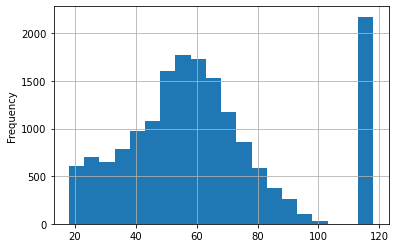

In [ ]:
profile.age.plot(kind='hist', bins=20)
plt.grid()

There's a huge outliers for the age approaching 120.

In [ ]:
# check the vounts for age greater than 100
profile[profile.age > 100].age.value_counts()

118    2175
101       5
Name: age, dtype: int64

There's something fishy here. The number of agaes equal to 118 is 2175. Earlier, we found that the number of `NaNs` for each `gender` and `income` column is also 2175. Maybe, they have relationship each other. Let's check it.

In [ ]:
# check if each two-nan in 'gender' & 'income' cols occurs indicate "118" in 'age' col
print("Number of NaN-118-age rows not occuring simultenously:")
profile.shape[0] - (profile.gender.isnull() == (profile.age > 101)).sum()

Number of NaN-118-age rows not occuring simultenously:


0

In [ ]:
profile[profile.gender.isnull()]

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN


Every time a value in `gender` col is `None`, the corresponding values in both `age` and `income` cols must be `118` and `NaN` respectively. This pattern might not be a coincidence. This might indicate to those users who registered to the Starbucks app without providing gender, age, and income info. In other words, those values are default values for users with unavailable data.

Therefore, we should get rid of those `NaNs`.

In [ ]:
# check the descriptve statistics
profile.describe(include='all')

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,17000,14825.000000
unique,3,NaN,17000,1716,NaN
top,M,NaN,6a8bb00f18204adb8a7c73d60f503853,2017-12-07 00:00:00,NaN
freq,8484,NaN,1,43,NaN
first,NaN,NaN,NaN,2013-07-29 00:00:00,NaN
last,NaN,NaN,NaN,2018-07-26 00:00:00,NaN
mean,NaN,62.531412,NaN,NaN,65404.991568
std,NaN,26.738580,NaN,NaN,21598.299410
min,NaN,18.000000,NaN,NaN,30000.000000
25%,NaN,45.000000,NaN,NaN,49000.000000


## Explore `transcript` dataset

In [ ]:
transcript.info()
transcript.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

The `transcript` dataset doesn't have any missing value. The `value` column has dict-like values. We will break it down little bit later. For the `person` column, to make it more consistent, we're going to rename it to `customer_id`.

In [ ]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [ ]:
# check 'value' col
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

In [ ]:
# check unique keys in 'value' col
tmp_value = transcript.value.apply(lambda row: list(row.keys())) \
            .apply(lambda row: row[0] if len(row) == 1 else ', '.join(row))
tmp_value.unique()

array(['offer id', 'amount', 'offer_id, reward'], dtype=object)

There are 4 unique keys in the `value` column. But that should be just three keys as the `offer id` and `offer_id` must refer to the same thing.

In [ ]:
def split_value_col(dict_row):
    """used to split the 'value' col"""

    # get the dict and replace the ' ' in the 'offer id'
    dict_row = {k.replace(' ', '_'): v for k, v in dict_row.items()}

    available_keys = ['offer_id', 'amount', 'reward'] # set the keys we want

    # loop through each key to check what key available
    output = []
    for key in available_keys:
        if key in dict_row.keys():
            output.append(dict_row[key])
        else:
            output.append(np.nan)

    return pd.Series(output)

In [ ]:
# split the 'value' col
tmp_value = transcript.value.apply(split_value_col) \
            .rename(columns={0: 'offer_id',
                             1: 'amount',
                             2: 'reward'})

# and concat it
transcript = pd.concat([transcript, tmp_value], axis=1) \
                .drop(columns='value')

In [ ]:
transcript.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [ ]:
# check the unique counts for 'offer_id'
print(transcript.offer_id.unique())
print(transcript.offer_id.nunique())

['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' 'f19421c1d4aa40978ebb69ca19b0e20d'
 '2298d6c36e964ae4a3e7e9706d1fb8c2' '3f207df678b143eea3cee63160fa8bed'
 'ae264e3637204a6fb9bb56bc8210ddfd' '5a8bc65990b245e5a138643cd4eb9837' nan]
10


There are 10 unique `offer_id` while there exist `NaNs`.

In [ ]:
# check the data where 'offer_id' is null
transcript[transcript.offer_id.isnull()]

,customer_id,event,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN


The `offer_id` which is not listed in the `portfolio` dataset (i.e. indicating by `NaN`) only occurs at the `event` equal to `transaction` and the `amount` has a value. This is understandable since a transaction made by a customer does not mean an offer is provided.

In [ ]:
# check unique value of 'event' col
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

## Join all datasets

Now, let's join all three datasets.

In [ ]:
display(profile.head())
transcript.head()

,gender,age,customer_id,income,registered_year,registered_month,registered_day,registered_weekday,registered_week
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,6,6
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,5,28
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,3,28
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,19
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,4,31


,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [ ]:
print(profile.shape)
transcript.shape

(17000, 9)


(306534, 7)

First, let's join both `profile` and `transcript` datasets. The key used here is the `customer_id` column.

In [ ]:
# check if customer_id in both profile & transcript has the same unique counts
(profile.customer_id.value_counts().index.sort_values() != \
 transcript.customer_id.value_counts().index.sort_values()) \
.sum()

0

In [ ]:
# join both datasets
tmp_df = pd.merge(transcript, profile, how='left', on='customer_id')

In [ ]:
tmp_df.head()

,customer_id,event,time,offer_id,amount,reward,gender,age,income,registered_year,registered_month,registered_day,registered_weekday,registered_week
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,100000.0,2017,5,9,1,19
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,NaN,2017,8,4,4,31
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,70000.0,2018,4,26,3,17
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,NaN,2017,9,25,0,39
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,NaN,2017,10,2,0,40


In [ ]:
tmp_df.shape

(306534, 14)

Next, let's join the previous result with the `portfolio` dataset`.

In [ ]:
# change 'reward' col name in order to distinguish it with the 'reward' col in 'transcript' dataset
portfolio.rename(columns={'reward': 'reward_std'}, inplace=True)

In [ ]:
# join then sort its values
df = pd.merge(tmp_df, portfolio, how='left', on='offer_id')
df.sort_values(['customer_id', 'time'], inplace=True)

del tmp_df

In [ ]:
display_all(df.head(20), 'column')

,customer_id,event,time,offer_id,amount,reward,gender,age,income,registered_year,registered_month,registered_day,registered_weekday,registered_week,reward_std,difficulty,duration,offer_type,email,mobile,social,web
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,M,33,72000.0,2017,4,21,4,16,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,M,33,72000.0,2017,4,21,4,16,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,M,33,72000.0,2017,4,21,4,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,33,72000.0,2017,4,21,4,16,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,33,72000.0,2017,4,21,4,16,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,M,33,72000.0,2017,4,21,4,16,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,8.57,NaN,M,33,72000.0,2017,4,21,4,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,M,33,72000.0,2017,4,21,4,16,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,M,33,72000.0,2017,4,21,4,16,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,M,33,72000.0,2017,4,21,4,16,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0


In [ ]:
df.shape

(306534, 22)

In [ ]:
# save the final result
df.to_csv('data/joint_data.csv', index=False)
print("Saved successfully!")

Saved successfully!


# Preprocessing

In [ ]:
# load clean data
df = pd.read_csv('data/joint_data.csv')

In [ ]:
# see the descriptive statistics
display_all(df.describe(include='all'), 'column')

,customer_id,event,time,offer_id,amount,reward,gender,age,income,registered_year,registered_month,registered_day,registered_weekday,registered_week,reward_std,difficulty,duration,offer_type,email,mobile,social,web
count,306534,306534,306534.000000,167581,138953.000000,33579.000000,272762,306534.000000,272762.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,167581.00000,167581.000000,167581.000000,167581,167581.0,167581.000000,167581.000000,167581.000000
unique,17000,4,NaN,10,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,94de646f7b6041228ca7dec82adb97d2,transaction,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bogo,NaN,NaN,NaN,NaN
freq,51,138953,NaN,20241,NaN,NaN,155690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71617,NaN,NaN,NaN,NaN
mean,NaN,NaN,366.382940,NaN,12.777356,4.904137,NaN,60.909367,64337.000755,2016.476032,6.701710,15.886153,3.029527,27.399486,4.41991,7.850401,6.610737,NaN,1.0,0.917944,0.656996,0.806858
std,NaN,NaN,200.326314,NaN,30.250529,2.886647,NaN,26.032030,21243.762941,1.199589,3.500048,8.765044,2.006800,15.294352,3.37336,5.048944,2.136130,NaN,0.0,0.274451,0.474714,0.394765
min,NaN,NaN,0.000000,NaN,0.050000,2.000000,NaN,18.000000,30000.000000,2013.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.000000,3.000000,NaN,1.0,0.000000,0.000000,0.000000
25%,NaN,NaN,186.000000,NaN,2.780000,2.000000,NaN,43.000000,48000.000000,2016.000000,4.000000,8.000000,1.000000,14.000000,2.00000,5.000000,5.000000,NaN,1.0,1.000000,0.000000,1.000000
50%,NaN,NaN,408.000000,NaN,8.890000,5.000000,NaN,57.000000,62000.000000,2017.000000,7.000000,16.000000,3.000000,29.000000,5.00000,10.000000,7.000000,NaN,1.0,1.000000,1.000000,1.000000
75%,NaN,NaN,528.000000,NaN,18.070000,5.000000,NaN,72.000000,78000.000000,2017.000000,10.000000,24.000000,5.000000,41.000000,5.00000,10.000000,7.000000,NaN,1.0,1.000000,1.000000,1.000000


As explained earlier, we assume that the age equal to 118 means default value for unavailable data. Therefore, we're going to remove those ages.

In [ ]:
# remove incomplete age data
df = df[df.age < 118]

Text(0.5, 0, 'Age')

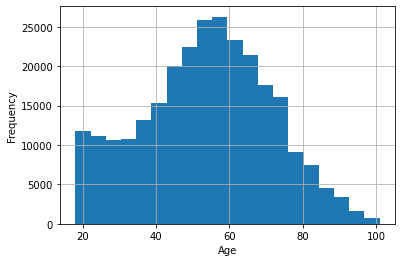

In [ ]:
df.age.plot(kind='hist', bins=20)
plt.grid()
plt.xlabel('Age')

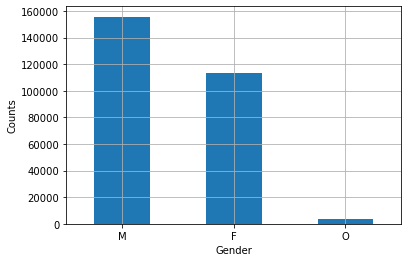

In [ ]:
# check the distribution for 'age' col
df.gender.value_counts().plot(kind='bar')
plt.grid()
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.xticks(rotation=0);

In [ ]:
df.head()

,customer_id,event,time,offer_id,amount,reward,gender,age,income,registered_year,...,registered_weekday,registered_week,reward_std,difficulty,duration,offer_type,email,mobile,social,web
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,M,33,72000.0,2017,...,4,16,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,M,33,72000.0,2017,...,4,16,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,M,33,72000.0,2017,...,4,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,33,72000.0,2017,...,4,16,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,33,72000.0,2017,...,4,16,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0


Next, we're going to transform the categorical columns. We will implement two kinds of categorical encoding, i.e. the label encoding and one-hot encoding. Our strategy is as follows:

**label encoding:** `event` and `offer_type` cols<br>
**one-hot encoding:** `gender` col

The description about when we should use either of them over the other is explained clearly in this [analyticsvidhya article](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/).

In [ ]:
# see the unique values
df.offer_type.unique()

array(['informational', nan, 'bogo', 'discount'], dtype=object)

The main reason why we implement label encoding to the `offer_type` column is because as explained in the beginning, the most offer is BOGO; the least one is informational; while the `NaNs` values indicate offers for the transaction event. Therefore, we have the ordinal numbers here:<br>
- high: `BOGO`
- medium: `discount`
- low: `informational`
- unwanted: `NaN`

In [ ]:
# create the encode/decode dict
offer_type_dict_encode = {np.nan: 0,
                          'informational': 1,
                          'discount': 2,
                          'bogo': 3}
offer_type_dict_decode = {v: k for k, v in offer_type_dict_encode.items()}

For the `event` column, we're going to implement the same as the `offer_type` column. The right order descendingly would be `offer completed`, `transaction`, `offer viewed`, and `offer received`.

In [ ]:
pd.Series(df.event.unique())

0     offer received
1       offer viewed
2        transaction
3    offer completed
dtype: object

In [ ]:
# create the encode/decode dict
event_dict_decode = pd.Series(df.event.unique()).to_dict()
event_dict_encode = {v: k for k, v in event_dict_decode.items()}

From now on, we will transform the `df` into a different dataframe for preparing the dataset for modelling. Therefore, we will make a copy `df`.

In [ ]:
XY = df.copy()

# implement label encoding
XY['offer_type'] = XY.offer_type.map(offer_type_dict_encode)
XY['event'] = XY.event.map(event_dict_encode)

In [ ]:
# one hot encoding
XY = pd.concat([XY, pd.get_dummies(XY.gender)], axis=1) \
        .drop(columns='gender')

In [ ]:
XY.head()

,customer_id,event,time,offer_id,amount,reward,age,income,registered_year,registered_month,...,difficulty,duration,offer_type,email,mobile,social,web,F,M,O
0,0009655768c64bdeb2e877511632db8f,0,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,33,72000.0,2017,4,...,0.0,3.0,1,1.0,1.0,1.0,0.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,1,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,33,72000.0,2017,4,...,0.0,3.0,1,1.0,1.0,1.0,0.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,2,228,NaN,22.16,NaN,33,72000.0,2017,4,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1,0
3,0009655768c64bdeb2e877511632db8f,0,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,33,72000.0,2017,4,...,0.0,4.0,1,1.0,1.0,0.0,1.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,1,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,33,72000.0,2017,4,...,0.0,4.0,1,1.0,1.0,0.0,1.0,0,1,0


In [ ]:
# for modelling, we dont need identification cols as they cause bias
cols2drop = ['customer_id', 'offer_id', 'reward_std']
XY.drop(columns=cols2drop, inplace=True)

In [ ]:
XY.dtypes

event                   int64
time                    int64
amount                float64
reward                float64
age                     int64
income                float64
registered_year         int64
registered_month        int64
registered_day          int64
registered_weekday      int64
registered_week         int64
difficulty            float64
duration              float64
offer_type              int64
email                 float64
mobile                float64
social                float64
web                   float64
F                       uint8
M                       uint8
O                       uint8
dtype: object

In [ ]:
XY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123957 entries, 2 to 306533
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event               123957 non-null  int64  
 1   time                123957 non-null  int64  
 2   amount              123957 non-null  float64
 3   reward              0 non-null       float64
 4   age                 123957 non-null  int64  
 5   income              123957 non-null  float64
 6   registered_year     123957 non-null  int64  
 7   registered_month    123957 non-null  int64  
 8   registered_day      123957 non-null  int64  
 9   registered_weekday  123957 non-null  int64  
 10  registered_week     123957 non-null  int64  
 11  difficulty          0 non-null       float64
 12  duration            0 non-null       float64
 13  offer_type          123957 non-null  int64  
 14  email               0 non-null       float64
 15  mobile              0 non-null    

Our target for modelling will be the `amount' column. As such a column still has missing values, we're going to remove them.

In [ ]:
# remove missing values
XY = XY[XY.amount.notnull()]

For the remaining columns that still have `NaNs`, we're going to check the number of unique values of each. If any column has only one unique value, we will drop the column.

In [ ]:
unimportant_cols = []
for col in XY.columns:
    # if only 1 unique value
    if XY[col].nunique() < 2:
        print(col, XY[col].unique())
        unimportant_cols.append(col)
    else: # if >= 2 unique values
        print(col, XY[col].nunique())

event [2]
time 120
amount 5036
reward [nan]
age 84
income 91
registered_year 6
registered_month 12
registered_day 31
registered_weekday 7
registered_week 53
difficulty [nan]
duration [nan]
offer_type [0]
email [nan]
mobile [nan]
social [nan]
web [nan]
F 2
M 2
O 2


As seen above, we don't need `event`, `reward`, `difficulty`, `offer_type`, `email`, `mobile`, `social`, and `web` columns.


In [ ]:
XY.drop(columns=unimportant_cols, inplace=True)

In [ ]:
XY.isnull().sum()

time                  0
amount                0
age                   0
income                0
registered_year       0
registered_month      0
registered_day        0
registered_weekday    0
registered_week       0
F                     0
M                     0
O                     0
dtype: int64

In [ ]:
display_all(XY.head(), 'column')

,time,amount,age,income,registered_year,registered_month,registered_day,registered_weekday,registered_week,F,M,O
2,228,22.16,33,72000.0,2017,4,21,4,16,0,1,0
6,414,8.57,33,72000.0,2017,4,21,4,16,0,1,0
10,528,14.11,33,72000.0,2017,4,21,4,16,0,1,0
13,552,13.56,33,72000.0,2017,4,21,4,16,0,1,0
15,576,10.27,33,72000.0,2017,4,21,4,16,0,1,0


In [ ]:
# save the prepared dataset for modelling
XY.to_csv('data/model_dataset.csv', index=False)
print('Saved successfully!')

Saved successfully!


# Modelling

## Preparing

In [ ]:
# load dataset
XY = pd.read_csv('data/model_dataset.csv')

<AxesSubplot:>

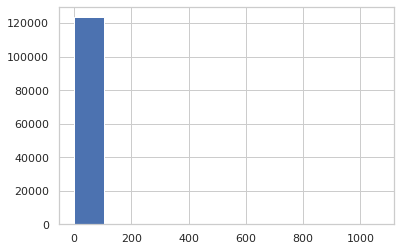

In [ ]:
# see the distribution of target col
XY.amount.hist()

There's a huge gap in the distribution. Let's see it in boxplot

<AxesSubplot:xlabel='amount'>

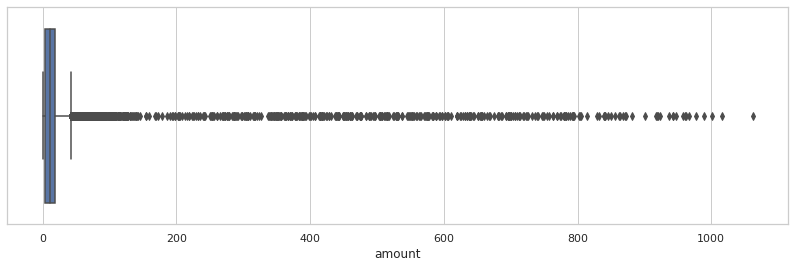

In [ ]:
plt.figure(figsize=(14, 4))
sns.set_theme(style="whitegrid")
sns.boxplot(x=XY.amount)

A lot of outliers identified. We can also see them by using the quantiles. There's a big gap between the median and the max value. Let's remove those outliers.

In [ ]:
XY.amount.describe()

count    123957.000000
mean         13.996325
std          31.749420
min           0.050000
25%           3.660000
50%          10.800000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

In [ ]:
# set the upper value of IQR
Q3 = XY.amount.describe()['75%']
Q1 = XY.amount.describe()['25%']
IQR = Q3 - Q1
upper = Q3 + (1.5*IQR)
upper

42.334999999999994

In [ ]:
# see the proportion of outliers
XY[XY.amount > upper].amount.shape[0] / XY.shape[0] * 100

0.8075380978887841

In [ ]:
# remove outliers
XY = XY[XY.amount <= upper]

<AxesSubplot:>

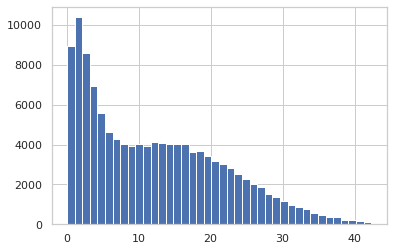

In [ ]:
# see the distribution after removing outliers
XY.amount.hist(bins=40)

Now, it's much better.

Next, let's see the correlation among all features.

<AxesSubplot:>

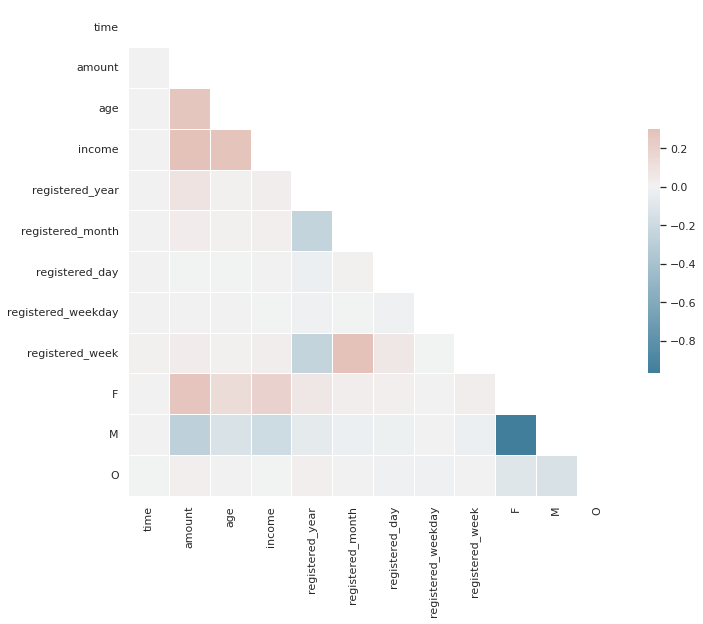

In [ ]:
# Generate a mask for the upper triangle
XY_corr = XY.corr()
mask = np.triu(np.ones_like(XY_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(XY_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nice. No multicollinearity found in the dataset, except the correlation between `M` and `F`. This occurs since both share the same value, i.e. either 0 or 1.

However, what makes challenging here is that each correlation between `amount` and other columns doesn't have strong value. This will make our models struggling to find accurate prediction.

In [ ]:
display_all(XY.head(), 'column')

,time,amount,age,income,registered_year,registered_month,registered_day,registered_weekday,registered_week,F,M,O
2,228,22.16,33,72000.0,2017,4,21,4,16,0,1,0
6,414,8.57,33,72000.0,2017,4,21,4,16,0,1,0
10,528,14.11,33,72000.0,2017,4,21,4,16,0,1,0
13,552,13.56,33,72000.0,2017,4,21,4,16,0,1,0
15,576,10.27,33,72000.0,2017,4,21,4,16,0,1,0


In [ ]:
XY.shape

(122956, 12)

Divide the final dataset into the input features and target label. Then, split those into train set and test set.

In [ ]:
X = XY.drop(columns='amount').values
y = XY.amount.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.075,
                                                    random_state=0)

In [ ]:
# check the proportion
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(113734, 11) (9222, 11)
(113734,) (9222,)


In [ ]:
# scale the X datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# to make it easier for later modelling, let's save the datsets
np.save('data/X_train_scaled.npy', X_train_scaled)
np.save('data/X_test_scaled.npy', X_test_scaled)
np.save('data/y_train.npy', y_train)
np.save('data/y_test.npy', y_test)

In [2]:
# load the datasets
X_train_scaled = np.load('data/X_train_scaled.npy')
X_test_scaled = np.load('data/X_test_scaled.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

## Build models

We will use 4 types of models, i.e. Random Forest, Gradient Boosing, Auto Sklearn, and Neural Network. For the first two models, we're going to use `scikit-learn` library. For the third one, `Auto Sklearn` library will be used. This library will automate many algorithms from `scikit-learn` in order to find the best composed algorithm for your problem. Finally, we will implement a neural network with middle-deep network. The library used will be `PyTorch`.

### Random Forest

In [ ]:
# instantiate the model. just use the default parameters
regressor = RandomForestRegressor(random_state=0)
regressor.fit(X_train_scaled, y_train) # train the model

RandomForestRegressor(random_state=0)

### Gradient Boosting

In [ ]:
# instantiate the model. just use the default parameters
regressor_GB = GradientBoostingRegressor(random_state=0)
regressor_GB.fit(X_train_scaled, y_train) # train the model

GradientBoostingRegressor(random_state=0)

### Auto Sklearn

For more detail about how to use this library, you can read it [here](https://automl.github.io/auto-sklearn/master/api.html#regression).

In [ ]:
automl = AutoSklearnRegressor(time_left_for_this_task=3600,
                              per_run_time_limit=600,
                              # n_jobs=-1, # in case you wanna use multiprocess
                              resampling_strategy='cv',
                              resampling_strategy_arguments={'folds': 4},
                              seed=0,
                              tmp_folder='/tmp/autosklearn_regression_tmp')

In [ ]:
# this will take up to 1 hour as time_left_for_this_task equal to 3600
automl.fit(X_train_scaled, y_train, dataset_name='starbucks_predict_amount')

AutoSklearnRegressor(per_run_time_limit=600, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 4}, seed=0,
                     tmp_folder='/tmp/autosklearn_regression_tmp')

Afterwards, we can see the best model found by `Auto Sklearn`.

In [ ]:
print(automl.leaderboard())

          rank  ensemble_weight            type      cost   duration
model_id                                                            
4            1              1.0  ard_regression  0.472278  16.586985


Unfortunately, `Auto Sklearn` just found 1 best model. If you want `Auto Sklearn` to find other best model possibilites, you could tune the arguments in the `AutoSklearnRegressor()` class above.

### Neural Nets

In order to use `PyTorch` NN model, we should tune many things. If you want to train the NN model using GPU, but you maybe don't have a CUDA GPU installed on your local computer, then you could use [Google Colab](https://research.google.com/colaboratory/) as I did.

In [ ]:
# Convert the numpy arrays to tensors
X_train = torch.from_numpy(X_train_scaled.astype(np.float32)).to(device='cuda') #.view(-1,1)
y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1,1).to(device='cuda')

X_val = torch.from_numpy(X_test_scaled.astype(np.float32)).to(device='cuda') #.view(-1,1)
y_val = torch.from_numpy(y_test.astype(np.float32)).view(-1,1).to(device='cuda')

In [ ]:
#Create dataset loaders
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

We're going use an NN model with architecture as follows:
- ReLU(n_input, 16)
- ReLU(16, 64)
- ReLU(64, 8)
- Linear(8, n_output)

This architecture is merely arbitrary. You could define better architecture if you want to.

In [ ]:
# define layer
class LinearRegression(nn.Module):

    def __init__(self, n_feature:int, n_output:int):
        super(LinearRegression, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, 16)   # hidden layer 1
        self.hidden2 = torch.nn.Linear(16, 64)   # hidden layer 2
        self.hidden3 = torch.nn.Linear(64, 8)   # hidden layer 3
        self.predict = torch.nn.Linear(8, n_output)   # output layer

    def forward(self, x):
        # set activation function for hidden layers
        x = nn.functional.relu(self.hidden1(x))
        x = nn.functional.relu(self.hidden2(x))
        x = nn.functional.relu(self.hidden3(x))

        y_pred = self.predict(x) # linear output
        return y_pred

In [ ]:
#Training loop
def train(model: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          val_loader: torch.utils.data.DataLoader,
          n_epochs: int,
          lr: float) -> nn.Module:
    
    #Loss and optimizer
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #Train weigths
    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            #Zero the parameter gradients
            optimizer.zero_grad()

            #Forward propagation
            pred_y = model(inputs)

            #Compute loss
            loss = criterion(pred_y,labels)

            #Backward propagration to compute gradient
            loss.backward()

            #Update parameters
            optimizer.step()

        # Evaluate model on validation data
        mse_val = 0
        for inputs, labels in val_loader:
            mse_val += torch.sum(torch.pow(labels - model(inputs), 2)).item()

        mse_val /= len(val_loader.dataset)

        print(f'Epoch: {epoch + 1}: Val MSE: {mse_val}')

    return model

In [ ]:
# set the GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Initialize mmodel

n_features = X_train.shape[1]
n_output = y_train.shape[1]

model = LinearRegression(n_features, n_output)
model.to(device)

print(model)

LinearRegression(
  (hidden1): Linear(in_features=11, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=64, bias=True)
  (hidden3): Linear(in_features=64, out_features=8, bias=True)
  (predict): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
#Train model

n_epochs = 200
lr = 0.0001

model = train(model, train_loader, val_loader, n_epochs, lr)

Epoch: 1: Val MSE: 62.88089407542553
Epoch: 2: Val MSE: 49.800009908450704
Epoch: 3: Val MSE: 46.626468348208384
Epoch: 4: Val MSE: 45.6697479095823
Epoch: 5: Val MSE: 45.06635710485223
Epoch: 6: Val MSE: 44.56061029775467
Epoch: 7: Val MSE: 44.178059664188304
Epoch: 8: Val MSE: 43.81400991525445
Epoch: 9: Val MSE: 43.53632945927537
Epoch: 10: Val MSE: 43.33712027456051
Epoch: 11: Val MSE: 43.13052555796537
Epoch: 12: Val MSE: 42.95350293548525
Epoch: 13: Val MSE: 42.82298607413615
Epoch: 14: Val MSE: 42.736269240833316
Epoch: 15: Val MSE: 42.58080854810931
Epoch: 16: Val MSE: 42.486284784214845
Epoch: 17: Val MSE: 42.37160716308117
Epoch: 18: Val MSE: 42.29720411629513
Epoch: 19: Val MSE: 42.20240974964017
Epoch: 20: Val MSE: 42.11778063537293
Epoch: 21: Val MSE: 42.012093986820645
Epoch: 22: Val MSE: 41.99873411285725
Epoch: 23: Val MSE: 41.871654622184046
Epoch: 24: Val MSE: 41.83653500850018
Epoch: 25: Val MSE: 41.774574162308035
Epoch: 26: Val MSE: 41.71011805239636
Epoch: 27: Val

## Model Evaluation

In [ ]:
preds = regressor.predict(X_test_scaled)

print('Random Forest results:')
print("Test MAE score:", mean_absolute_error(y_test, preds))
print("Test MSE score:", mean_squared_error(y_test, preds))
print("Test RMSE score:", mean_squared_error(y_test, preds, squared=False))
print("Test R2 score:", r2_score(y_test, preds))

Random Forest results:
Test MAE score: 4.01857752295236
Test MSE score: 29.039960015361302
Test RMSE score: 5.388873724198898
Test R2 score: 0.6752137388815952


In [ ]:
preds_GB = regressor_GB.predict(X_test_scaled)

print('Gradient Boosting results:')
print("Test MAE score:", mean_absolute_error(y_test, preds_GB))
print("Test MSE score:", mean_squared_error(y_test, preds_GB))
print("Test RMSE score:", mean_squared_error(y_test, preds_GB, squared=False))
print("Test R2 score:", r2_score(y_test, preds_GB))

Gradient Boosting results:
Test MAE score: 4.9411972143356895
Test MSE score: 39.37320803447824
Test RMSE score: 6.274807410150389
Test R2 score: 0.5596455016125743


In [ ]:
test_predictions = automl.predict(X_test_scaled)
print('Auto-Sklearn results:')
print("Test MAE score:", mean_absolute_error(y_test, test_predictions))
print("Test MSE score:", mean_squared_error(y_test, test_predictions))
print("Test RMSE score:", mean_squared_error(y_test, test_predictions, squared=False))
print("Test R2 score:", r2_score(y_test, test_predictions))

Auto-Sklearn results:
Test MAE score: 5.166066412663035
Test MSE score: 42.61109913388565
Test RMSE score: 6.527717758442506
Test R2 score: 0.5234325542280458


In [ ]:
ann_preds = model(X_val)
ann_preds_arr = ann_preds.detach().cpu().numpy()

print('Neural Networks results:')
print("Test MAE score:", mean_absolute_error(y_test, ann_preds_arr))
print("Test MSE score:", mean_squared_error(y_test, ann_preds_arr))
print("Test RMSE score:", mean_squared_error(y_test, ann_preds_arr, squared=False))
print("Test R2 score:", r2_score(y_test, ann_preds_arr))

Neural Networks results:
Test MAE score: 4.938259281524995
Test MSE score: 39.653731068212814
Test RMSE score: 6.297120855455517
Test R2 score: 0.5565080996589887


## Model Improvement

As Random Forest performs the best so far, it is chosen for model improvement. We're going to use `scikit-learn`'s `GridSearchCV()` class. Fortunately, the parameters of the estimator used to apply this methods are [optimized by cross-validated grid-search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over a parameter grid.

In this case, I only specify combinations for 2 hyperparameters, i.e. `n_estimators` and `bootstrap`. Actually, I've tried several times the grid search trainings with the combinations of three, five, and six hyperparameters. But, my local computer always hangs every time I run a lot of grid search parameters combinations. I have tried a few solutions for this issue, i.e. [this solution](https://stackoverflow.com/a/47929603/12311481), [this solution](https://stackoverflow.com/a/43195753/12311481), and [this solution](https://stackoverflow.com/a/52686503/12311481). I also have reduced the `n_jobs` argument in `GridSearchCV()` to only 1. But, the issue resists so that I decide to reduce the number of hyperparameters to only two. Thankfully, the issue is solved when I only use combinations for 2 hyperparameters with only 1 `n_jobs`.

If you have a machine with more computing resources, you could run much more hyperparameter combinations, and even more regressors.

In [6]:
# instatantiate model
random_forest = RandomForestRegressor(random_state=1)

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

pipeline = Pipeline([
    ('regressor', DummyEstimator())
])

# set parameter grid
parameters = {'regressor': [random_forest],
              'regressor__bootstrap': (True, False),
              'regressor__n_estimators': (100, 150),
#               'regressor__criterion': ("mse", "mae"),
#               'regressor__max_depth': (16, 32, None),
#               'regressor__min_samples_split': (2, 4),
#               'regressor__max_features': ('auto', 'sqrt', 'log2')
             }

# instantiate grid search
cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2) #, n_jobs=5)

In [7]:
# see all parameters defined
cv.__dict__

{'scoring': None,
 'estimator': Pipeline(steps=[('regressor', DummyEstimator())]),
 'n_jobs': None,
 'iid': 'deprecated',
 'refit': True,
 'cv': None,
 'verbose': 2,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'regressor': [RandomForestRegressor(random_state=1)],
  'regressor__bootstrap': (True, False),
  'regressor__n_estimators': (100, 150)}}

In [8]:
# train the model
# be aware, in my local computer, this takes around 1 hour to train the model
cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100, total=  35.4s
[CV] regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


[CV]  regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100, total=  35.9s
[CV] regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100 
[CV]  regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100, total=  37.3s
[CV] regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100 
[CV]  regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100, total=  38.1s
[CV] regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100 
[CV]  regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=100, total=  35.8s
[CV] regressor=RandomForestRegressor(random_state=1), regressor__bootstrap=True, regressor__n_estimators=150 
[CV]  regressor=RandomForestRegressor(random_state=1), regre

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 20.5min finished


GridSearchCV(estimator=Pipeline(steps=[('regressor', DummyEstimator())]),
             param_grid={'regressor': [RandomForestRegressor(n_estimators=150,
                                                             random_state=1)],
                         'regressor__bootstrap': (True, False),
                         'regressor__n_estimators': (100, 150)},
             verbose=2)

In [21]:
import joblib

# save all models from grid search
joblib.dump(cv, 'model/random_forest_cv.pkl')

# or just save the best model
joblib.dump(cv.best_estimator_,
            'model/random_forest_cv_best.pkl',
            compress = 1)

# load model for further usage
# joblib.load("model/random_forest_cv.pkl")
# joblib.load("model/random_forest_cv_best.pkl")

['model/random_forest_cv_best.pkl']

The GridSearchCV is trained on the train set. As mentioned by the training result above, there are 20 fits executed in which the number comes from 4 model candidates times 5 folds. Let's see the grid search results. The results are ranked from the best to the worst.

In [10]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_results = cv_results.sort_values('rank_test_score') \
                .reset_index(drop=True)

# see top 5 model
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__bootstrap,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,54.529981,1.801157,1.250979,0.092244,"RandomForestRegressor(n_estimators=150, random...",True,150,{'regressor': RandomForestRegressor(n_estimato...,0.673344,0.675615,0.684226,0.679782,0.680973,0.678788,0.003874,1
1,35.672614,0.989614,0.830134,0.072640,"RandomForestRegressor(n_estimators=150, random...",True,100,{'regressor': RandomForestRegressor(n_estimato...,0.672104,0.674852,0.683133,0.678727,0.680102,0.677784,0.003892,2
2,94.650032,3.195302,1.569572,0.104199,"RandomForestRegressor(n_estimators=150, random...",False,150,{'regressor': RandomForestRegressor(n_estimato...,0.449470,0.456676,0.475503,0.462111,0.460983,0.460949,0.008523,3
3,55.752678,0.871721,0.947497,0.047821,"RandomForestRegressor(n_estimators=150, random...",False,100,{'regressor': RandomForestRegressor(n_estimato...,0.449479,0.456608,0.475476,0.461964,0.461032,0.460912,0.008514,4


In [16]:
print('Best Random Forest by GridSearchCV:', end='\n\n')

best_one = cv_results.loc[0, :]
for col, val in best_one.iteritems():
    if isinstance(val, dict):
        continue
    else:
        print(f"{col}: {val}")

Best Random Forest by GridSearchCV:

mean_fit_time: 54.52998065948486
std_fit_time: 1.8011565878631346
mean_score_time: 1.2509790420532227
std_score_time: 0.09224405935467567
param_regressor: RandomForestRegressor(n_estimators=150, random_state=1)
param_regressor__bootstrap: True
param_regressor__n_estimators: 150
split0_test_score: 0.6733440090880394
split1_test_score: 0.6756150618444681
split2_test_score: 0.6842256125426528
split3_test_score: 0.67978155710127
split4_test_score: 0.6809727172793605
mean_test_score: 0.6787877915711582
std_test_score: 0.003873818499603785
rank_test_score: 1


In [12]:
# test the model on test set
cv_preds = cv.predict(X_test_scaled)

print('Grid Search CV results:')
print("Test MAE score:", mean_absolute_error(y_test, cv_preds))
print("Test MSE score:", mean_squared_error(y_test, cv_preds))
print("Test RMSE score:", mean_squared_error(y_test, cv_preds, squared=False))
print("Test R2 score:", r2_score(y_test, cv_preds))

Grid Search CV results:
Test MAE score: 4.007854061543652
Test MSE score: 28.859437861418773
Test RMSE score: 5.372098087471856
Test R2 score: 0.6772327194654879


## Take away points

From all models, we can see that each model performs standard results. Random Forest provides the best performance in this case. Even, the NN model which should give better performance is unable to deliver best performance. After we improve the Random Forest model by using Grid Search backed by 5-fold Cross Validation, it is expected the model would have much better performance. However, sadly, its performance just improves slightly.

# Conclusions

## Reflection

I found this project challenging, mainly due to the structure of the data in the `transcript` dataset. My goal is to predict the amount will spent by a customer. So, the decision makers would now how customers behave in purchasing Starbucks products. Therefore, I need all rows with amount existing, i.e. the rows with `event` col equal to `transaction`. However, using only this subset of dataset, in fact, the models I've implemented can't give good performance. Even, by checking the correlations among all columns, we are unable to capture any strong relationship between amount and other columns.

Perhaps, in order to get broader factors, we should consider the other events, i.e. `offer received`, `offer viewed`, and `offer completed`. But, if we include the three, we will have many missing values. This is contradictory.

## Potential improvements

Due to time reasons, I don't have a chance to perform enhancement on data or model tuning. For example, I could do more experiments on feature engineering to see if adding/substracting features can improve the model; or I could try other combinations of model hyperparameters to see if this will affect the model performance.

In addition, the analysis and modelling should also consider the condition of customers who don't make any transaction as such a condition also provide more insight.

Last but not least, the computing resources should also be considered. In my case, where I need GPU computing, I have to go to Google Colab. But unfortunately, when I need more CPU computings for Grid Search, I 've found Google Colab doesn't provide multiprocessing. Likewise, my local computer also doesn't give sufficient multprocessing computing performance for the case. I think, for handling real world data for enterprises or startups, it wouldn't be excessive to rent any cloud computing.